# Quality Prediction in a Mining Process by using RNN

In this notebook, we are going to predict how much impurity is in the ore concentrate. As this impurity is measured every hour, if we can predict how much silica (impurity) is in the ore concentrate, we can help the engineers, giving them early information to take actions. Hence, they will be able to take corrective actions in advance (reduce impurity, if it is the case) and also help the environment (reducing the amount of ore that goes to tailings as you reduce silica in the ore concentrate). To this end, we are going to use the dataset **Quality Prediction in a Mining Process Data** from [Kaggle](https://www.kaggle.com/edumagalhaes/quality-prediction-in-a-mining-process/home). 

In order to have a clean notebook, some functions are implemented in the file *utils.py* (e.g., plot_loss_and_accuracy). 

Summary:
 - [Data Pre-processing](#data_preprocessing)
     - [Data Visualisation](#data_viz)
     - [Data Normalisation](#normalisation)
 - [Building the Models](#models)
     - [Splitting the Data into Train and Test Sets](#split)
     - [Gated Recurrent Unit (GRU)](#gru)
     - [Long-short Term Memory (LSTM)](#lstm)
  
__All the libraries used in this notebook are <font color='red'>Open Source</font>__.

In [1]:
# Standard libraries - no deep learning yet
import numpy as np # written in C, is faster and robust library for numerical and matrix operations
import pandas as pd # data manipulation library, it is widely used for data analysis and relies on numpy library.
import matplotlib.pyplot as plt # for plotting
from datetime import datetime # supplies classes for manipulating dates and times in both simple and complex ways

from utils import *

# the following to lines will tell to the python kernel to alway update the kernel for every utils.py
# modification, without the need of restarting the kernel.
# Of course, for every motification in util.py, we need to reload this cell
%load_ext autoreload
%autoreload 2
%matplotlib inline

Using TensorFlow backend.


## Data Pre-processing
<a id='data_preprocessing'></a>

**First download the dataset (click [here](https://www.kaggle.com/edumagalhaes/quality-prediction-in-a-mining-process/download)) unzip quality-prediction-in-a-mining-process.zip**

The **Quality Prediction in a Mining Process Data** includes ([Kaggle](https://www.kaggle.com/edumagalhaes/quality-prediction-in-a-mining-process/home)):

 - The first column shows time and date range (from march of 2017 until september of 2017). Some columns were sampled every 20 second. Others were sampled on a hourly base. *This make the data processing harder, however, for this tutorial we will not re-sample the data*.
 - The second and third columns are quality measures of the iron ore pulp right before it is fed into the flotation plant. 
 - Column 4 until column 8 are the most important variables that impact in the ore quality in the end of the process. 
 - Column 9 until column 22, we can see process data level and air flow inside the flotation columns, which also impact in ore quality. 
 - The last two columns are the final iron ore pulp quality measurement from the lab. Target is to predict the last column, which is the % of silica in the iron ore concentrate.


We are going to use [Pandas](https://pandas.pydata.org/) for the data processing. The function  [read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) is going to be used to read the csv file.

In [2]:
dataset = pd.read_csv('../data/MiningProcess_Flotation_Plant_Database.csv',index_col=0, decimal=",")

# Set the index name to 'date'
dataset.index.name = 'date'

dataset.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,250.576,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,250.862,...,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,250.313,...,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,250.049,...,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,249.895,...,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31


Given our time and computational resources restrictions, we are going to select the first 100,000 observations for this tutorial.

In [3]:
dataset = dataset.iloc[:100000,:]

### Data Visualisation
<a id='data_viz'></a>

<AxesSubplot:xlabel='date', ylabel='Silica Concentrate'>

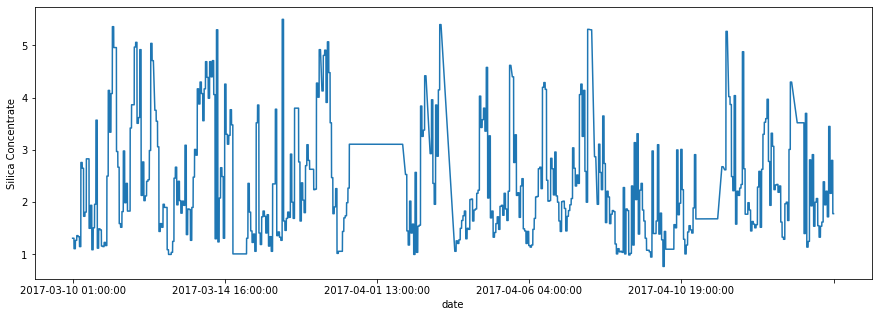

In [4]:
# Ploting the Silica Concentrate
plt.figure(figsize = (15, 5))
plt.xlabel("x")
plt.ylabel("Silica Concentrate")

dataset['% Silica Concentrate'].plot()

## Data Normalisation
<a id='normalisation'></a>

Here are going to normalise all the features and transform the data into a supervised learning problem. The features to be predicted are removed, as we would like to predict just the *Silica Concentrate* (last element in every feature array).

### Transforming the data into a supervised learning problem

This step will involve framing the dataset as a **supervised learning problem**. As we would like to predict the "silica concentrate", we will set the corresponding column to be the output (label $y$).

We would like to predict the silica concentrate ( $y_t$) at the current time ($t$) given the measurements at the prior time steps (lets say $t-1, t-2, \dots t-n$, in which $n$ is the number of past observations to be used to forcast $y_t$).

The function **create_window** (see _utils.py_) converts the time-series to a supervised learning problem. The new dataset is constructed as a **DataFrame**, with each column suitably named both by variable number and time step, for example, $var1(t-1)$ for **%Iron Feed** at the previous observation ($t-1$). This allows you to design a variety of different time step sequence type forecasting problems from a given univariate or multivariate time series.

In [5]:
# Scikit learn libraries
from sklearn.preprocessing import MinMaxScaler #Allows normalisation

# Convert the data to float
values = dataset.values.astype('float32')

# Normalise features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Specify the number of lag
n_in = 5
n_features = 23

# Transform the time-series to a supervised learning problem representation
reframed = create_window(scaled, n_in = n_in, n_out = 1, drop_nan = True)

# Summarise the new frames (reframes) 
print(reframed.head(1))

   var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  var5(t-5)  var6(t-5)  \
5   0.476715   0.502299   0.483124   0.665398   0.459145   0.641907   

   var7(t-5)  var8(t-5)  var9(t-5)  var10(t-5)  ...  var14(t)  var15(t)  \
5   0.660635   0.377486   0.432691      0.4025  ...  0.382131   0.41283   

   var16(t)  var17(t)  var18(t)  var19(t)  var20(t)  var21(t)  var22(t)  \
5  0.375913    0.4394  0.535916  0.559504  0.511396  0.516056  0.875677   

   var23(t)  
5  0.114165  

[1 rows x 138 columns]


## Building the Models
<a id='models'></a>
So far, we just preprocessed the dataset. Now, we are going to build the following sequential models:
 
 - [Gated Recurrent Unit (GRU)](#gru)
 - [Long Short-Term Memory (LSTM)](#lstm)
 
The models consists in a **many_to_one** architecture, in which the input is a **sequence** of the past observations and the output is the predicted value (in this case with dimension equal 1). 

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU

from sklearn.metrics import mean_squared_error # allows compute the mean square error to performance analysis

### Splitting the Data into Train and Test Sets
<a id='split'></a>

In [7]:
# split into train and test sets
values = reframed.values

# We will use 80% of the data for training and 20% for testing
n_train = round(0.8 * dataset.shape[0])
train = values[:n_train, :]
test = values[n_train:, :]

# Split into input and outputs
n_obs = n_in * n_features # the number of total features is given by the number of past 
                          # observations * number of features. In this case we have
                          # 5 past observations and 23 features, so the number of total 
                          # features is 115.
x_train, y_train = train[:, :n_obs], train[:, n_features-1] # note that fore y_train, we are removing 
                                                             # just the last observation of the 
                                                             # silica concentrate
x_test, y_test = test[:, :n_obs], test[:, n_features-1]
print('Number of total features (n_obs): ', x_train.shape[1])
print('Number of samples in training set: ', x_train.shape[0])
print('Number of samples in testing set: ', x_test.shape[0])

# Reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], n_in, n_features))
x_test = x_test.reshape((x_test.shape[0], n_in, n_features))

Number of total features (n_obs):  115
Number of samples in training set:  80000
Number of samples in testing set:  19995


### Gated Recurrent Unit (GRU)
<a id='gru'></a>

To build the model, we are going use the following components from Keras:

 - [Sequencial](https://keras.io/models/sequential/): allows us to create models layer-by-layer. 
 - [GRU](https://keras.io/layers/recurrent/): provides a GRU architecture
 - [Dense](https://keras.io/layers/core/): provides a regular fully-connected layer
 - [Activation](https://keras.io/activations/): defines the activation function to be used

Basically, we can define the sequence of the model by using _Sequential()_:

```python
    model = Sequential()
    model.add(GRU(...))
    ...
```
where the function _add(...)_ that stack the layers. Once created the model, we can configure the training by using the function [compile](https://keras.io/models/model/). Here we need to define the [loss](https://keras.io/losses/) function (mean squared error, mean absolute error, cosine proximity, among others.) and the [optimizer](https://keras.io/optimizers/) (Stochastic gradient descent, RMSprop, adam, among others), as follows:

```python
    model.compile(loss = "...", 
                  optimizer = "...")
```

Also, we have the option to see a summary representation of the model by using the function [summary](https://keras.io/models/about-keras-models/#about-keras-models). This function summarises the model and tell us the number of parameters that we need to tune.

LLPS-2022-02-03: 

* the ```model_gru.add(GRU...``` below rises *"NotImplementedError: Cannot convert a symbolic Tensor (gru_2/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported"

* problem seems to be related to numpy version in this Docker image rio_cs_p1 haridoop/cs_p1:latest, which is '1.21.2'. LLPS ```np.__version__``` is '1.20.3' and works!

* People report that TF was built with 'numpy ~= 1.19.2' so, thats the reason! REF: https://github.com/tensorflow/tensorflow/issues/47242

In [8]:
np.__version__

'1.20.3'

In [9]:
# Define the model.
model_gru = Sequential()

# the input_shape is the number of past observations (n_in) and the number of features 
# per past observations (23)
model_gru.add(GRU(input_shape=(x_train.shape[1], x_train.shape[2]), 
                        units = 128, 
                        return_sequences = False))

model_gru.add(Dense(units=1)) 

# We compile the model by defining the mean absolute error (denoted by mae) as loss function and
# adam as optimizer
model_gru.compile(loss = "mae", 
                  optimizer = "adam")

# just print the model
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 128)               58368     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 58,497
Trainable params: 58,497
Non-trainable params: 0
_________________________________________________________________


### Training the Model
<a id=train></a>

Once defined the model, we need to train it by using the function [fit](https://keras.io/models/model/). This function performs the optmisation step. Hence, we can define the following parameters such as:

 - batch size: defines the number of samples that will be propagated through the network
 - epochs: defines the number of times in which all the training set (x_train_scaled) are used once to update the weights
 - validation split: defines the percentage of training data to be used for validation
 - among others (click [here](https://keras.io/models/model/) for more information)
 
This function return the _history_ of the training, that can be used for further performance analysis.

In [10]:
# Training
hist_gru = model_gru.fit(x_train, y_train, 
                        epochs=50, 
                        batch_size=256, 
                        validation_split = 0.1,
                        verbose=1, # To not print the output, set verbose=0
                        shuffle=False) 

2022-02-15 19:23:47.171351: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2022-02-15 19:23:47.195175: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2599990000 Hz
2022-02-15 19:23:47.196555: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559e8c3002c0 executing computations on platform Host. Devices:
2022-02-15 19:23:47.196576: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2022-02-15 19:23:47.235100: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line fl

Train on 72000 samples, validate on 8000 samples
Epoch 1/50
72000/72000 [==============================] - 6s 81us/step - loss: 0.0985 - val_loss: 0.0307
Epoch 2/50
72000/72000 [==============================] - 6s 81us/step - loss: 0.0679 - val_loss: 0.0542
Epoch 3/50
72000/72000 [==============================] - 6s 84us/step - loss: 0.0624 - val_loss: 0.0319
Epoch 4/50
72000/72000 [==============================] - 6s 85us/step - loss: 0.0388 - val_loss: 0.0306
Epoch 5/50
72000/72000 [==============================] - 6s 84us/step - loss: 0.0375 - val_loss: 0.0237
Epoch 6/50
72000/72000 [==============================] - 6s 85us/step - loss: 0.0268 - val_loss: 0.0240
Epoch 7/50
72000/72000 [==============================] - 6s 86us/step - loss: 0.0213 - val_loss: 0.0151
Epoch 8/50
72000/72000 [==============================] - 6s 82us/step - loss: 0.0231 - val_loss: 0.0172
Epoch 9/50
72000/72000 [==============================] - 6s 85us/step - loss: 0.0209 - val_loss: 0.0194
Epoch 

### Prediction and Performance Analysis
<a id='performance_gru'></a>

Here we can see if the model overfits or underfits. First, we are going to plot the 'loss' and the 'Accuracy' in from the training step.

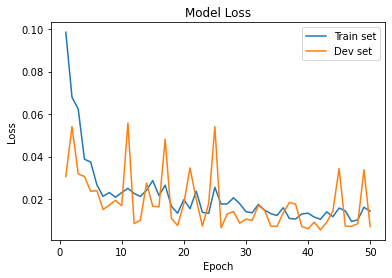

In [11]:
plot_loss(hist_gru)

Once the model was trained, we can use the function [predict](https://keras.io/models/model/) for  prediction tasks. We are going to use the function **inverse_transform** (see _utils.py_) to invert the scaling (transform the values to the original ones).

Given the predictions and expected values in their original scale, we can then compute the error score for the model.

In [12]:
yhat_gru = model_gru.predict(x_test)

# performing the inverse transform on test_X and yhat_rnn
inv_y_gru, inv_yhat_gru = inverse_transform_multiple(x_test, y_test, yhat_gru, scaler, n_in, n_features)

# calculate RMSE
mse_gru = mean_squared_error(inv_y_gru, inv_yhat_gru)
print('Test MSE: %.3f' % mse_gru)

Test MSE: 0.099


### Visualising the predicted Data

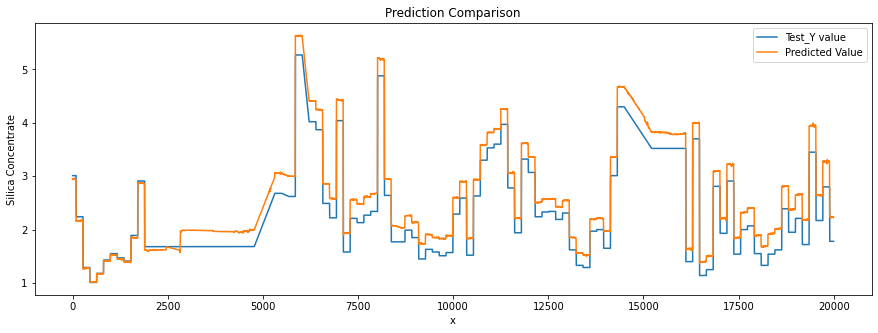

In [13]:
plot_comparison([inv_y_gru, inv_yhat_gru], 
                ['Test_Y value','Predicted Value'], 
                title='Prediction Comparison')

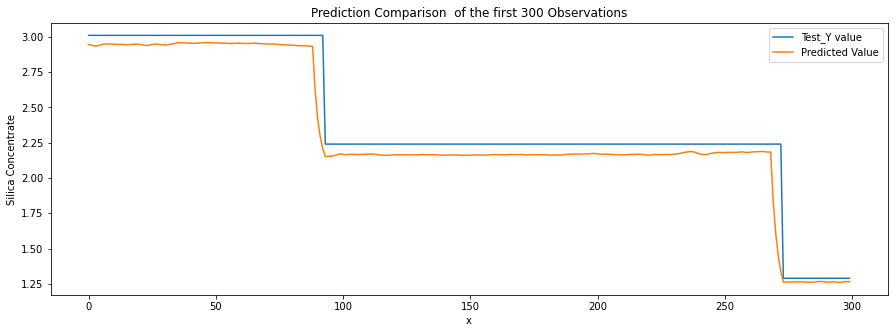

In [14]:
plot_comparison([inv_y_gru[0:300], inv_yhat_gru[0:300]], 
                ['Test_Y value', 'Predicted Value'], 
                title='Prediction Comparison  of the first 300 Observations')

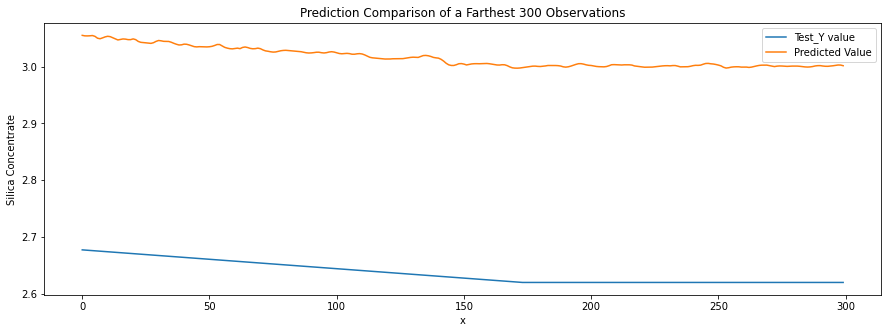

In [15]:
plot_comparison([inv_y_gru[5500:5800], inv_yhat_gru[5500:5800]], 
                ['Test_Y value', 'Predicted Value'], 
                title='Prediction Comparison of a Farthest 300 Observations')

### Long-Short Term Memory (LSTM)
<a id='lstm'></a>

Now **you** are going to build the model based on LSTM. Like GRU, we are going use the following components from Keras:

 - [Sequencial](https://keras.io/models/sequential/): allows us to create models layer-by-layer. 
 - [LSTM](https://keras.io/layers/recurrent/): provides a LSTM architecture
 - [Dense](https://keras.io/layers/core/): provides a regular fully-connected layer
 - [Activation](https://keras.io/activations/): defines the activation function to be used

Basically, you are going to define the sequence of the model by using _Sequential()_:

```python
    model = Sequential()
    model.add(LSTM(...))
    ...
```

and configure the training by using the function [compile](https://keras.io/models/model/):

```python
    model.compile(loss = "...", 
                  optimizer = "...")
```

Follow the below steps for this task.

**Step 1**: Create the model:
 1) Define the number of layers (we suggest at this stage to use just one, but it is up to you)
 2) Create the fully connected layer
    
For example:

```python
# Define the model.
model_lstm = Sequential()

# Stacking just one LSTM
model_lstm.add(LSTM(input_shape=(train_X.shape[1], train_X.shape[2]), 
                        units = 128, 
                        return_sequences = False))

# Fully connected layer
model_lstm.add(Dense(units=1)) 

```

**Step 2**: Configure the training:
 1) Define the loss function (e.g., 'mae' for mean average error or 'mse' for mean squared error)
 2) Define the optimiser (e.g., 'adam', 'rmsprop',  'sgd', 'adagrad, etc)
    
For example:

```python
model_lstm.compile(loss = "mae", 
                  optimizer = "adam")

```

**Step 3:** Call the function 
```python
model_lstm.summary()
```
to summarise the model.

**Step 4:** Defined the number of epochs, validation_split and batch_size that best fit for you model and call the function fit to train the model.

For example:
```python
hist_lstm = model_lstm.fit(x_train, y_train, 
                           epochs=50, 
                           batch_size=256, 
                           validation_split = 0.1,
                           verbose=1, shuffle=False) 
```

#### Using the history 

Here we can see if the model overfits or underfits

In [ ]:
plot_loss(hist_lstm)

In [ ]:
yhat_lstm = model_lstm.predict(x_test)

# performing the inverse transform on test_X and yhat_rnn
inv_y_lstm, inv_yhat_lstm = inverse_transform_multiple(x_test, y_test, yhat_lstm, scaler, n_in, n_features)

# calculate RMSE
mse_lstm = mean_squared_error(inv_y_lstm, inv_yhat_lstm)
print('Test MSE: %.3f' % mse_lstm)

### Visualising the predicted Data

In [ ]:
plot_comparison([inv_y_lstm, inv_yhat_lstm], 
                ['Test_Y value','Predicted Value'], 
                title='Prediction Comparison')

In [ ]:
plot_comparison([inv_y_lstm[0:300], inv_yhat_lstm[0:300]], 
                ['Test_Y value', 'Predicted Value'], 
                title='Prediction Comparison  of first 300 Observations')

In [ ]:
plot_comparison([inv_y_lstm[5500:5800], inv_yhat_lstm[5500:5800]], 
                ['Test_Y value', 'Predicted Value'], 
                title='Prediction Comparison of a Farthest 300 Observations')

## Models comparison

**Exercise**: run the code below and discuss the results.

In [ ]:
plot_comparison([inv_y_lstm[0:300],
                 inv_yhat_gru[0:300], inv_yhat_lstm[0:300]], 
                ['Original', 'GRU', 'LSTM'], 
                title='Prediction Comparison  of the First 300 Observations')

In [ ]:
plot_comparison([inv_y_lstm[5500:5800], 
                 inv_yhat_gru[5500:5800], inv_yhat_lstm[5500:5800]], 
                ['Original', 'GRU', 'LSTM'], 
                title='Prediction Comparison of a Farthest 300 Observations')

In [ ]:
print('Comparing the MSE of the three models:')
print('  GRU: ', mse_gru)
print('  LSTM: ', mse_lstm)